## Step1: Imort Data

In [1]:
from ExtractSpec import *
import glob
import os 
from pathlib import Path
# Testing automatically find data file
from pathlib import Path
from ExtractSpec.paths import DATA_DIR, RESULTS_DIR, require, cd

# Check the data directory is right
print("DATA:", DATA_DIR)
print("RESULTS:", RESULTS_DIR, '\n')

# Data Preparation
os.chdir(DATA_DIR)
fitls = glob.glob('*.fits')
print(fitls)
data_dict = create_data_dict(fitls,check_header= True, check_file_header='TMC1A_g140h-f100lp_s3d.fits')
# 'TMC1A_g235h.x1d', 'TMC1A_g140h.x1d', 'TMC1A_g140h.s3d', 'TMC1A_g395h.x1d', 'TMC1A_g235h.s3d', 'TMC1A_g395h.s3d'

DATA: /media/kuo-jui/data/ISM_finalproject/data
RESULTS: /media/kuo-jui/data/ISM_finalproject/2025Fall_ISM_Project/results 

['TMC1A_g235h-f170lp_x1d.fits', 'TMC1A_g140h-f100lp_x1d.fits', 'TMC1A_g140h-f100lp_s3d.fits', 'TMC1A_g395h-f290lp_x1d.fits', 'TMC1A_g235h-f170lp_s3d.fits', 'TMC1A_g395h-f290lp_s3d.fits']
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   53                                                  
NAXIS2  =                   55                                                  
NAXIS3  =                 3915                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extensi

## Step2: Overview the image and spectrum

No valid patch input, skipping...


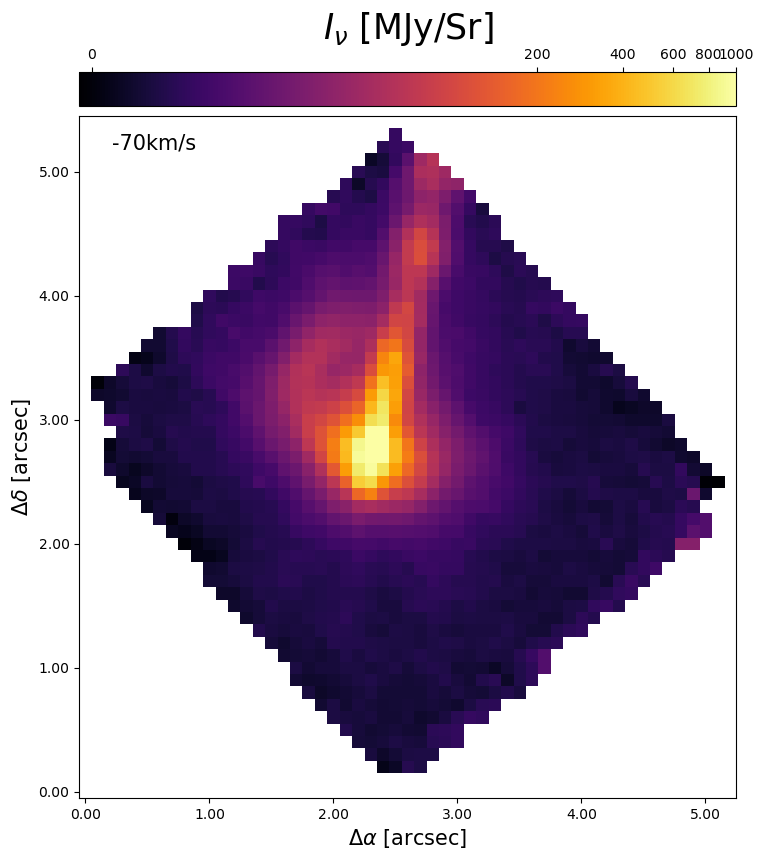

In [2]:
# Plot the raw image, g140 
import matplotlib.pyplot as plt
import matplotlib as mpl


data = data_dict['TMC1A_g140h.s3d']['data']
header = data_dict['TMC1A_g140h.s3d']['header']
# pixel = data_dict['TMC1A_g140h.s3d']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

plot_image(data[2866], header, vmin = -1, vmax = 1e3, a = 1e-2, text = '-70km/s', add_patch=True, savefig = False, save_name = 'g140_2865.png')


# Fe II 1.644: line center is at 2866
# HI Brackett-12 (1.6412) is at 2855

In [3]:
# Calculate the flux and wavelength of each channel
wave, flux = calc_spec(data, header = header)

# Try to find out the exclude region 1.44 ~ 1.4763
#print(wave[1800:2300])

Sr in pixel: 2.3504431239584476e-13
Begin to calculate spectrum flux without continuum subtraction...


Calculating spectrum flux: 100%|██████████| 3915/3915 [00:31<00:00, 126.07it/s]

Finish calculate spectrum flux without continuum subtraction!!
Return the wave and flux arrays.


In [ ]:

plot_line_spectrum(wave, header, flux, xlim = (-800,800), ylim = (-2e-3, 2e-2), 
                   text = ('1.644', 'FeII'), restwave = 1.644, exclude=[(1.44,1.4763)],
                   savefig = False, save_name = 'FeII1644_spectrum.png', plot_all_spec= True)
emission_dict = {
    'Fe_1.644': 1.644,
    'HI_Bracket_12': 1.6412,
    }



## Step3: Continuum subtraction using Sagov-filter
The method is based on JDISC program and ctool (https://github.com/pontoppi/ctool). After that we will correct the radial velocity.

### Explanation of Continuum Subtraction Process
The `calc_cont` function implements a robust method for continuum subtraction using median filtering and anchor points. Here's how it works:

1. **Median Filter**:
   - Uses `medfilt` with a specified box size (default=101)
   - Smooths the data by replacing each point with the median of its surrounding points
   - Helps remove noise while preserving sharp spectral features

2. **Anchor Points Selection**:
   - Identifies reliable continuum points using a threshold (default=0.998)
   - Points where smoothed flux > original flux × threshold become anchor points
   - If too few anchors found (< 2), relaxes threshold to 0.99
   - If still insufficient, falls back to using smoothed data

3. **Continuum Estimation**:
   - Uses linear interpolation between anchor points
   - Preserves the actual continuum shape without being affected by emission/absorption lines
   - Iterative process refines the estimate over multiple passes

4. **Final Smoothing**:
   - Applies Savitzky-Golay filter for final smoothing
   - Window size = 3 × boxsize
   - Uses first-order polynomial fit

This method is particularly effective because:
- Median filtering preserves sharp features
- Anchor points ensure we're using reliable continuum regions
- Interpolation helps avoid contamination from spectral lines
- Multiple iterations help refine the final result

This work is totally based on the ctool package.

In [6]:
# From previous result we can see that there are lots of bad pixel, so we first need to use shift coordinat and continuum subtraction
# Reminder: g140_s3d is the original data cube

from tqdm.notebook import tqdm

print(data[:, 30:31, 24:25].shape)

# Line emission extract from a spaxel
cont_one_spaxel, line_one_spaxel = generate_line_cont(data[:,30:31,24:25], wave, boxsize= 13 )

# Line emission including all of the spaxels
cont_spaxel, line_spaxel = generate_line_cont(data, wave, boxsize= 13 )



(3915, 1, 1)


Generating continuum and line emission cubes: 100%|██████████| 55/55 [00:04<00:00, 13.35it/s]


plotting single cross (tuple)
plotting single cross (tuple)
plotting single cross (tuple)


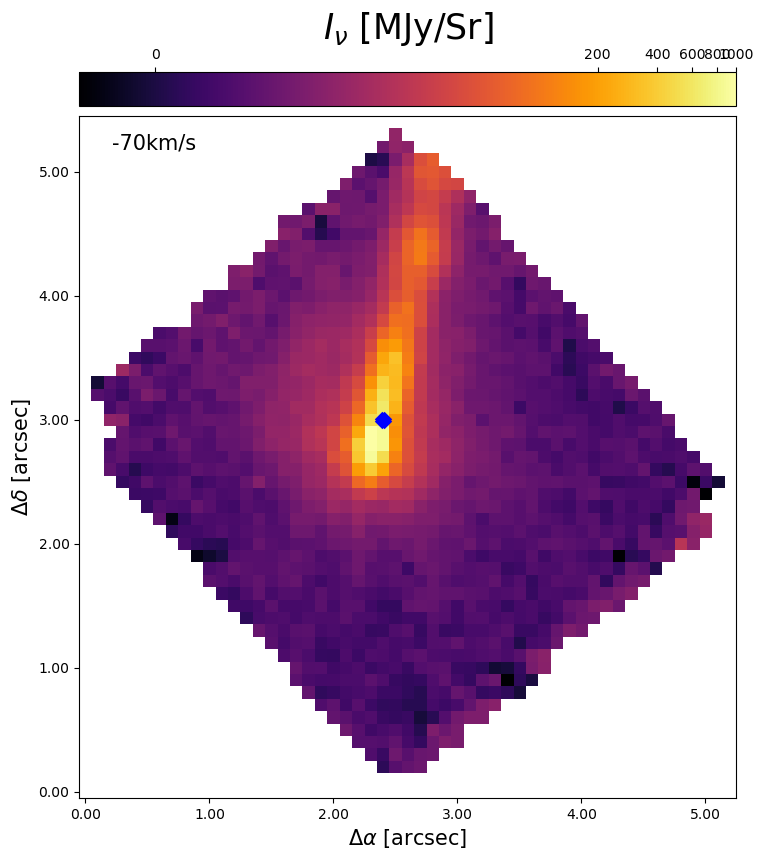

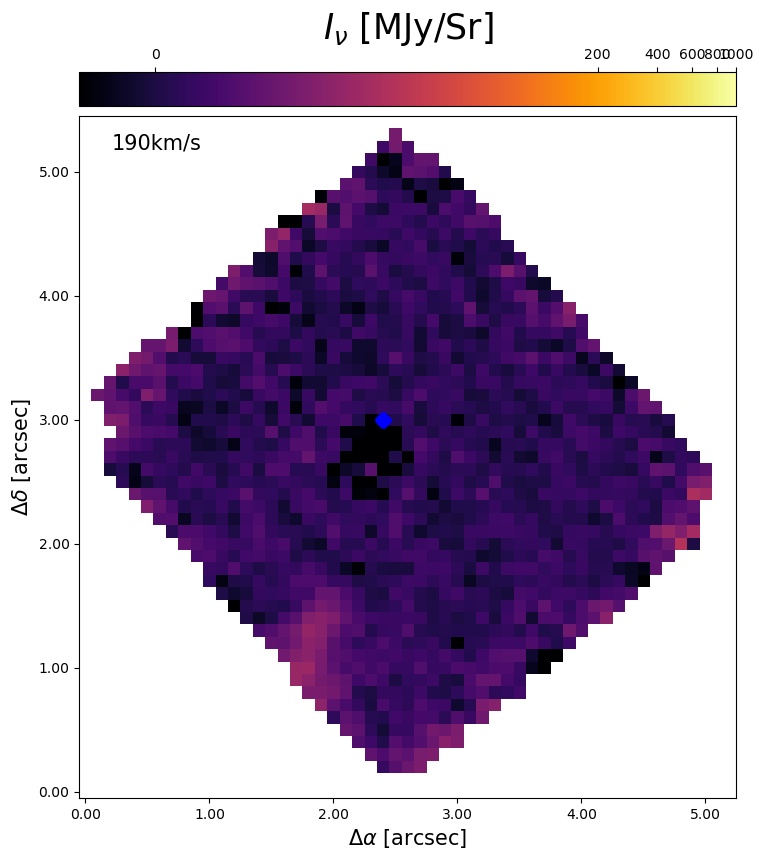

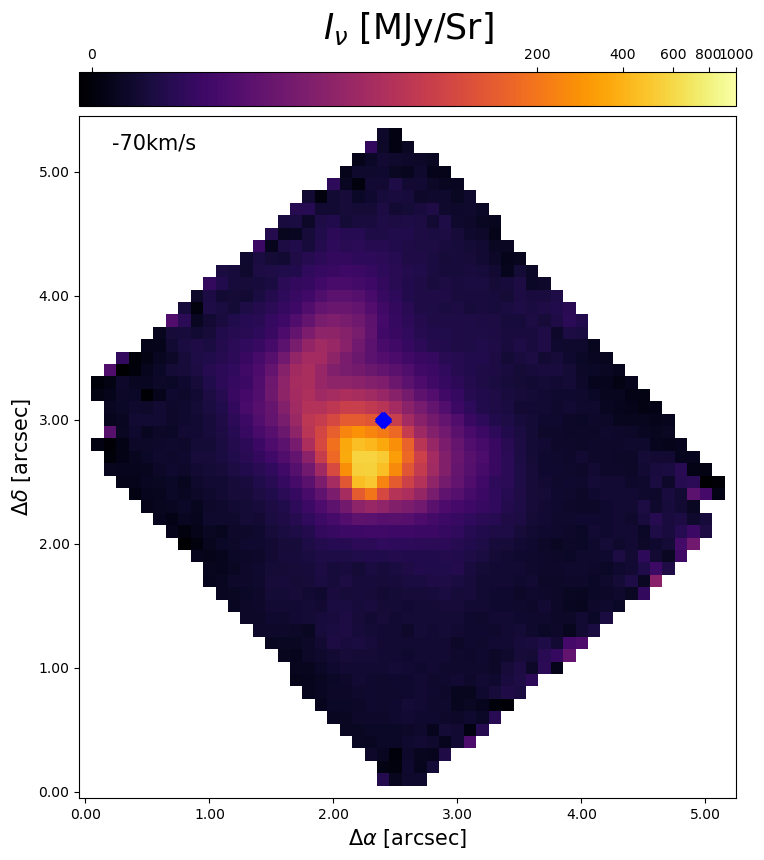

In [7]:
# Plot the continuum emission of the FeII 1.644
# The reddshift side might locate at 190 km/s index = 2871
plot_image(line_spaxel[2866], header, vmin = -1, vmax = 1e3, a = 1e-3, text = '-70km/s', add_patch= (24,30), savefig = False, save_name = 'line_2866.png')
plot_image(line_spaxel[2871], header, vmin = -1, vmax = 1e3, a = 1e-3, text = '190km/s', add_patch= (24,30), savefig = False, save_name = 'line_2871.png')
plot_image(cont_spaxel[2866], header, vmin = -1, vmax = 1e3, a = 1e-2, text = '-70km/s', add_patch= (24,30), savefig = False, save_name = 'cont_2866.png')

In [9]:
# Plot the spectrum with conntinuum subtraction, g140
cont, flux_line = calc_contsubtract_spec(line_one_spaxel, cont_one_spaxel, header = data_dict['TMC1A_g140h.s3d']['header'])
print(flux_line)


Sr in pixel: 2.3504431239584476e-13


Calculating spectrum flux with continuum subtraction: 100%|██████████| 3915/3915 [00:00<00:00, 49194.70it/s]

[ 3.95876661e-08  8.99362639e-08  1.02421121e-07 ...  1.95521175e-07
  2.62889833e-08 -7.19909283e-07]


In [10]:
v_1644 = optical_veocity(wave, header)
%matplotlib tk
# Plot the comparison between line and continuum emissions
#plot_comparison_line_continuum(v_1644, wave,  flux, flux_line, cont, plot_all_spec = True, savefig = False, save_name = 'Comparison_line_cont.png')

# The following shows an example of the extract spectrum of a spaxel
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize = (9,5))
plt.step(v_1644, np.array(flux_line)*1e3, where = 'mid', label = 'continuum-subtracted')
#plt.step(v_1644, np.array(cont)*1e3, where = 'mid', label = 'continuum')
plt.xlabel('velocity ' + r'$[km/s]$', fontsize = 15)
plt.ylabel(r'$F_\lambda$'+' [mJy]', fontsize = 15)
plt.xlim(-1000,1000)
plt.ylim(-3e-3,15e-2)
#plt.hlines(0,-1000, 1000,ls = '-', color = 'black')
plt.vlines(-510.95, -1e-3,15e-2, ls = '--', color = 'blue')
# Plot the vertical line
plt.text(-510.95+10, 6e-2, r'$HI-B\gamma $', rotation = 'vertical' )
plt.vlines(0, -1e-3,15e-2, ls = '--', color = 'red')
plt.text(0+10, 6e-2,  r'$FeII$', rotation = 'vertical' )
plt.title('FeII 1.644' + r'$\mu m$', fontsize = 15)
plt.legend()
os.chdir(RESULTS_DIR)
plt.savefig('FeII_1.644_emission_line.png')
os.chdir(DATA_DIR)


### Note
For Fe II boxsize =13 is enoug but for larger wavelegnth we need to use other size of box size. 

In [11]:
# Save the line data and continuum data in new fits file
import os
import astropy.io.fits as fits
# Create directory to save the new fits files

if not os.path.exists('subtract_continuum'):
    os.mkdir('subtract_continuum')
os.chdir('subtract_continuum')
# export continuum as *_cont.fits
header = data_dict['TMC1A_g140h.s3d']['header']
hdu_new = fits.PrimaryHDU(data = cont_spaxel, header = header)
hdu_new.writeto('TMC1A_g140h.s3d'+'_cont.fits', overwrite=True)
# export continuum as *_line.fits
hdu_new = fits.PrimaryHDU(data = line_spaxel, header = header)
hdu_new.writeto('TMC1A_g140h.s3d'+'_line.fits', overwrite=True)

## Step 4: Create Moment zero and one map by using bettermoments

In [ ]:
import bettermoments as bm
# Generate Moment zero and one map of FeII 1.644 the line emission
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)


cont_data, cont_wave = bm.load_cube('TMC1A_g140h.s3d_line.fits')

# Decide the moment map region [w1:w2]

rms = bm.estimate_RMS(data=cont_data[2840:2885, 10:15, 24:34 ], N=10) # set it in a line free region
print('RMS = {:.1f} mJy/beam (original)'.format(rms ))

w1, w2 = 2860, 2870
cont_data = cont_data[w1:w2]
cont_wave = cont_wave[w1:w2]
cont_vel = optical_veocity(cont_wave, w1644_rest)

user_mask = bm.get_user_mask(data= cont_data, user_mask_path=None)

threshold_mask = bm.get_threshold_mask(data= cont_data,
                                       clip= 1,
                                       smooth_threshold_mask=0.0)

channel_mask = bm.get_channel_mask(data = cont_data,
                                   firstchannel = 0,
                                   lastchannel = -1)

mask = bm.get_combined_mask(user_mask = user_mask, threshold_mask = threshold_mask, channel_mask = channel_mask, combine = 'and')
masked_data = cont_data *mask

moments = bm.collapse_zeroth(velax= cont_vel, data= masked_data, rms= rms)
bm.save_to_FITS(moments = moments, method= 'zeroth', path= filepath+"TMC1A_g140h.s3d_line.fits")

moments = bm.collapse_first(velax= cont_vel, data= masked_data, rms= rms)
bm.save_to_FITS(moments = moments, method= 'first', path= filepath+"TMC1A_g140h.s3d_line.fits")

RMS = 0.5 mJy/beam (original)


In [11]:
# Read the continuum moment 0 map
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)

fitls = glob.glob('*.fits')
subcont_dict = {}
for i in fitls:
    hdul = fits.open(i)
    header = hdul[0].header
    data = hdul[0].data
    name = i.split('.')[0] +'.' + i.split('.')[1]
    subcont_dict['%s' %(name)] = {'header': header, 'data': data}
print(subcont_dict.keys())
# dict_keys(['TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont'])

dict_keys(['TMC1A_g140h.s3d_line_M0', 'TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_line_dM0', 'TMC1A_g140h.s3d_line_M1', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont', 'TMC1A_g140h.s3d_line_dM1'])


Text(0.5, 1.0, 'MJy/Sr km/s')

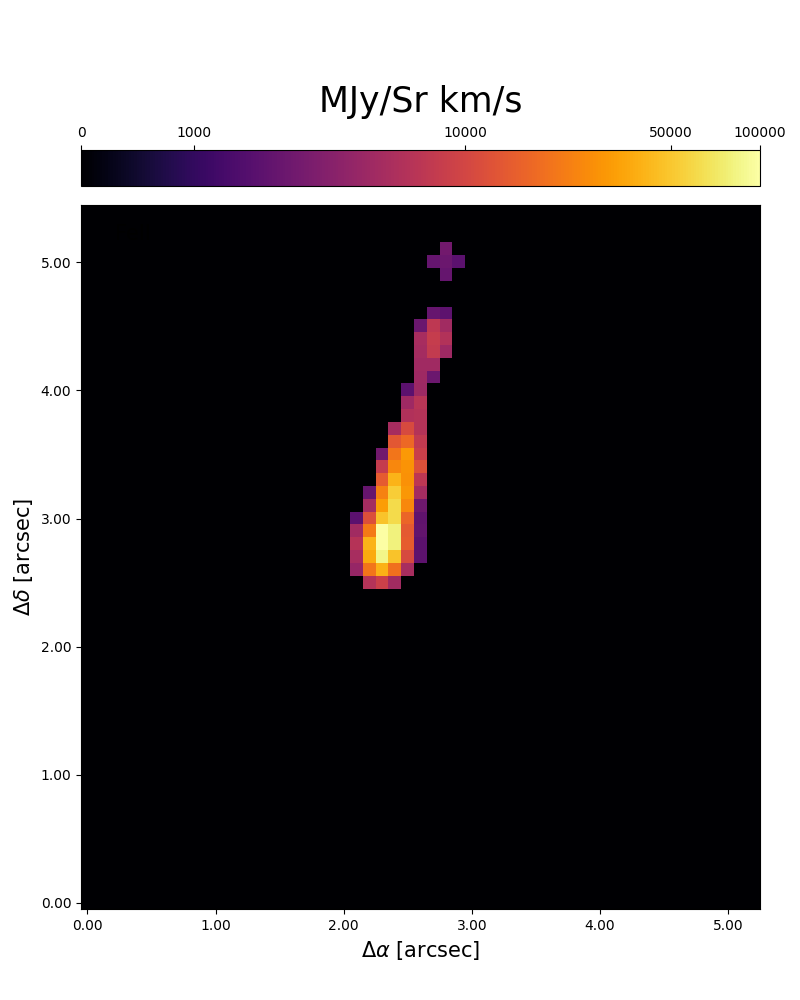

In [12]:
# Plot the Moment zero map of 1.644 line
g140_s3d_lint_M0 = subcont_dict['TMC1A_g140h.s3d_line_M0']['data']
pixel = subcont_dict['TMC1A_g140h.s3d_line_M0']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

def axis_transfer(pos,val):
    return f'{pos*pixel:.2f}'

fig = plt.figure(figsize = (8,10))

widths = [0.05,1]
heights = [0.05,1]
gs = fig.add_gridspec(2, 2, width_ratios=widths,height_ratios=heights)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.85, wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(gs[1,1])
cbar1 = fig.add_subplot(gs[0,1])
norm1 = ImageNormalize(g140_s3d_lint_M0, vmin= -1, vmax = 1e5, stretch=AsinhStretch(a=1e-2))
plt1 = ax1.imshow(g140_s3d_lint_M0, norm = norm1, cmap= 'inferno', origin = 'lower')
cb1 = Colorbar(ax = cbar1, mappable = plt1, orientation = 'horizontal', ticklocation = 'top', ticks = [0, 1e3, 1e4, 5e4, 1e5])

ax1.xaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.yaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.set_xlabel(r'$\Delta \alpha$' +' [arcsec]', fontsize = 15)
ax1.set_ylabel(r'$\Delta \delta$'+' [arcsec]',fontsize = 15)
ax1.text(0.05,0.95, 'FeII',transform=ax1.transAxes,fontsize = 15)
cbar1.set_title('MJy/Sr km/s',fontsize = 25, pad= 10)

Text(0.5, 1.0, 'km/s')

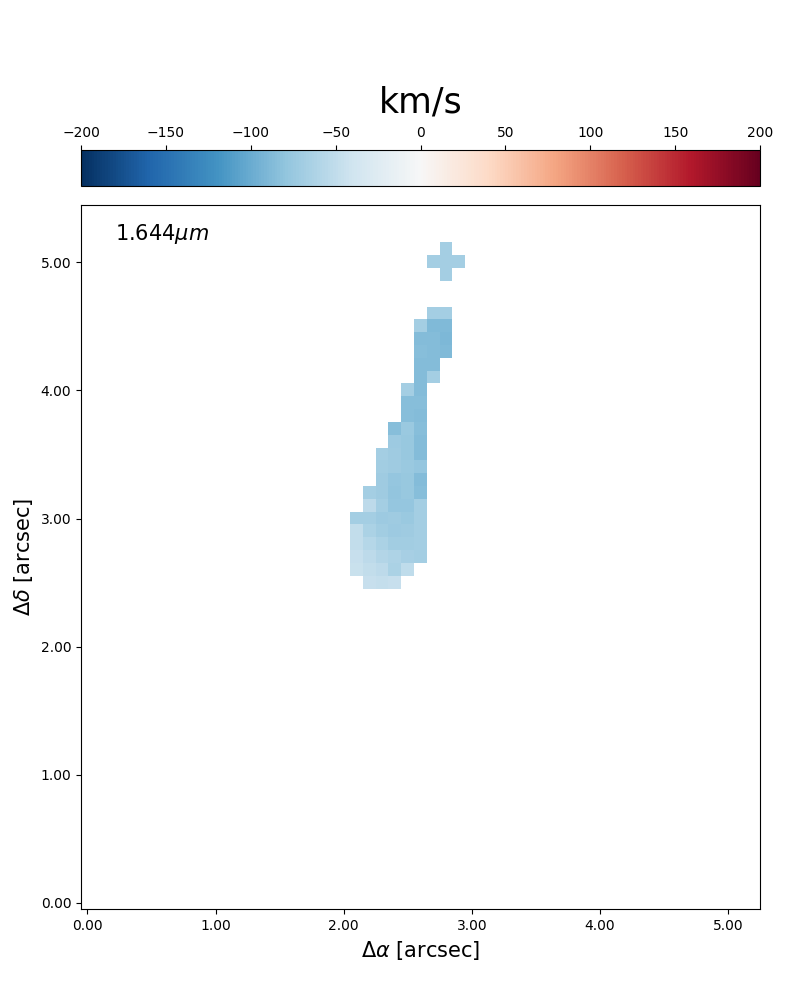

In [13]:
# Plot the Moment one map of 1.644 line
g140_s3d_line_M1 = subcont_dict['TMC1A_g140h.s3d_line_M1']['data']
pixel = subcont_dict['TMC1A_g140h.s3d_line_M1']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

def axis_transfer(pos,val):
    return f'{pos*pixel:.2f}'

fig = plt.figure(figsize = (8,10))

widths = [0.05,1]
heights = [0.05,1]
gs = fig.add_gridspec(2, 2, width_ratios=widths,height_ratios=heights)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.85, wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(gs[1,1])
cbar1 = fig.add_subplot(gs[0,1])
norm1 = ImageNormalize(g140_s3d_line_M1, vmin= -200, vmax = 200)
plt1 = ax1.imshow(g140_s3d_line_M1, norm = norm1, cmap= 'RdBu_r', origin = 'lower')
cb1 = Colorbar(ax = cbar1, mappable = plt1, orientation = 'horizontal', ticklocation = 'top')

ax1.xaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.yaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.set_xlabel(r'$\Delta \alpha$' +' [arcsec]', fontsize = 15)
ax1.set_ylabel(r'$\Delta \delta$'+' [arcsec]',fontsize = 15)
ax1.text(0.05,0.95, r'$1.644\mu m$',transform=ax1.transAxes,fontsize = 15)
cbar1.set_title('km/s',fontsize = 25, pad= 10)

In [14]:
# Generate Moment zero map of FeII 1.644 the continuum emission
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)


cont_data, cont_wave = bm.load_cube('TMC1A_g140h.s3d_cont.fits')

# Decide the moment map region [w1:w2]

rms = bm.estimate_RMS(data=cont_data[2840:2885, 10:15, 24:34 ], N=10) # set it in a line free region
print('RMS = {:.1f} mJy/beam (original)'.format(rms ))

w1, w2 = 2860, 2870
cont_data = cont_data[w1:w2]
cont_wave = cont_wave[w1:w2]
cont_vel = optical_veocity(cont_wave, w1644_rest)

user_mask = bm.get_user_mask(data= cont_data, user_mask_path=None)

threshold_mask = bm.get_threshold_mask(data= cont_data,
                                       clip= None,
                                       smooth_threshold_mask=0.0)

channel_mask = bm.get_channel_mask(data = cont_data,
                                   firstchannel = 0,
                                   lastchannel = -1)

mask = bm.get_combined_mask(user_mask = user_mask, threshold_mask = threshold_mask, channel_mask = channel_mask, combine = 'and')
masked_data = cont_data *mask

moments = bm.collapse_zeroth(velax= cont_vel, data= masked_data, rms= rms)
bm.save_to_FITS(moments = moments, method= 'zeroth', path= filepath+"TMC1A_g140h.s3d_line.fits")

#moments = bm.collapse_first(velax= cont_vel, data= masked_data, rms= rms)
#bm.save_to_FITS(moments = moments, method= 'first', path= filepath+"TMC1A_g140h.s3d_line.fits")

# Read the continuum moment 0 map
filepath = '/media/kuo-jui/data/ISM_finalproject/subtract_continuum/'
os.chdir(filepath)

fitls = glob.glob('*.fits')
subcont_dict = {}
for i in fitls:
    hdul = fits.open(i)
    header = hdul[0].header
    data = hdul[0].data
    name = i.split('.')[0] +'.' + i.split('.')[1]
    subcont_dict['%s' %(name)] = {'header': header, 'data': data}
print(subcont_dict.keys())
# dict_keys(['TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont'])

RMS = 0.2 mJy/beam (original)
dict_keys(['TMC1A_g140h.s3d_line_M0', 'TMC1A_g140h.s3d_line', 'TMC1A_g140h.s3d_line_dM0', 'TMC1A_g140h.s3d_line_M1', 'TMC1A_g140h.s3d_cont_dM0', 'TMC1A_g140h.s3d_cont_M0', 'TMC1A_g140h.s3d_cont', 'TMC1A_g140h.s3d_line_dM1'])


Text(0.5, 1.0, 'MJy/Sr km/s')

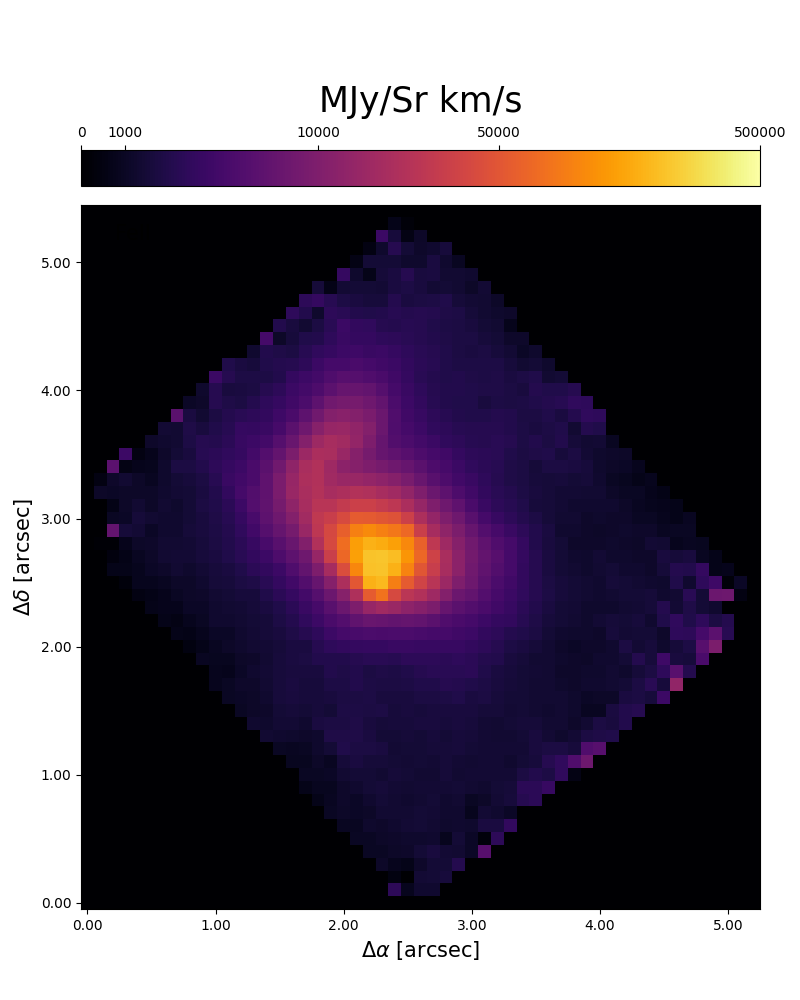

In [15]:
# Plot the raw image, g140 
g140_s3d_cont_M0 = subcont_dict['TMC1A_g140h.s3d_cont_M0']['data']
pixel = subcont_dict['TMC1A_g140h.s3d_cont_M0']['header']['CDELT1']*3600 # change the pixel unit  qfrom deg to arcsec

def axis_transfer(pos,val):
    return f'{pos*pixel:.2f}'

fig = plt.figure(figsize = (8,10))

widths = [0.05,1]
heights = [0.05,1]
gs = fig.add_gridspec(2, 2, width_ratios=widths,height_ratios=heights)
gs.update(left=0.05, right=0.95, bottom=0.08, top=0.85, wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(gs[1,1])
cbar1 = fig.add_subplot(gs[0,1])
norm1 = ImageNormalize(g140_s3d_cont_M0, vmin= -1, vmax = 5e5, stretch=AsinhStretch(a=5e-3))
plt1 = ax1.imshow(g140_s3d_cont_M0, norm = norm1, cmap= 'inferno', origin = 'lower')
cb1 = Colorbar(ax = cbar1, mappable = plt1, orientation = 'horizontal', ticklocation = 'top', ticks = [0, 1e3, 1e4, 5e4, 5e5])

ax1.xaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.yaxis.set_major_formatter(FuncFormatter(axis_transfer))
ax1.set_xlabel(r'$\Delta \alpha$' +' [arcsec]', fontsize = 15)
ax1.set_ylabel(r'$\Delta \delta$'+' [arcsec]',fontsize = 15)
ax1.text(0.05,0.95, 'FeII',transform=ax1.transAxes,fontsize = 15)
cbar1.set_title('MJy/Sr km/s',fontsize = 25, pad= 10)